# Imports

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import pickle
import heapq

# Read the Data from the file

In [2]:
with open('/kaggle/input/sherlock-holmes-dataset/1661-0.txt', 'r', encoding='utf-8') as file:
    text = file.read()

print('corpus length:', len(text))
print(text[:100])

corpus length: 583340
﻿The Adventures of Sherlock Holmes, by Arthur Conan Doyle


I. A SCANDAL IN BOHEMIA


I.


To Sherlo


# Tokenize and Create Uniue Word Dictionary
Now split the dataset into each word in order but without the presence of some special characters.

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
# Get the word index
word_index = tokenizer.word_index

total_words = len(tokenizer.word_index) + 1

print("tokenizer.word_index: ",len(tokenizer.word_index))
print("total_words: ",total_words)


tokenizer.word_index:  8922
total_words:  8923


Create the n-gram

In [4]:
input_sequences = []
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


print("input_sequences count",len(input_sequences))


input_sequences count 101463


#Pad and make all sequence the same length
padding should be added at the beginning of each sequence using the ‘padding=pre’ argument.


In [5]:
max_sequence_len = max([len(seq) for seq in input_sequences])
print("max_sequence_len", max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

max_sequence_len 20


#Prepare features(n-gram) against label
Let's create two numpy arrays x for storing the features and y for storing its corresponding label.

We will iterate x and y if the word is available so that the corresponding position becomes 1

In [6]:
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
print(X.shape)
print(y.shape)

(101463, 19)
(101463,)


Converting the output array into a suitable format for training a model, where each target word is represented as a binary vector.

In [7]:
y = np.array(tf.keras.utils.to_categorical(y, num_classes=total_words))
print(np.shape(y))

print("total_words",total_words)
print("max_sequence_len",max_sequence_len)

(101463, 8923)
total_words 8923
max_sequence_len 20


# Build Recurrent Neural Network
1.   The first layer added to the model is the ‘Embedding’ layer, which is responsible for converting the input sequences into dense vectors of fixed size. It takes three arguments:


*   ‘total_words’, which represents the total number of distinct words in the vocabulary;
*   ‘100’, which denotes the dimensionality of the word embeddings
*   ‘input_length’, which specifies the length of the input sequences.



2.   The next layer added is the ‘LSTM’ layer, a type of recurrent neural network (RNN) layer designed for capturing sequential dependencies in the data. It has 150 units, which means it will learn 150 internal representations or memory cells.

3.   Finally, the ‘Dense’ layer is added, which is a fully connected layer that produces the output predictions. It has ‘total_words’ units and uses the ‘softmax’ activation function to convert the predicted scores into probabilities, indicating the likelihood of each word being the next one in the sequence.

two Dropout layers with a dropout rate of 0.2, meaning 20% of the units will be dropped out during training.

Reasoning:

After Embedding: Applying dropout after the embedding layer can help prevent overfitting on specific word embeddings.
After LSTM: Applying dropout after the LSTM layer can help prevent the network from memorizing specific sequences in the training data.

In [9]:
# Use MirroredStrategy for multi-GPU support
strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs available: {strategy.num_replicas_in_sync}")

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store cross-validation results
fold_val_accuracies = []
fold_val_losses = []

# Define a function to create the model
def create_model(total_words,max_sequence_len):
    with strategy.scope():
        model = Sequential([
            Embedding(total_words, 100, input_length=max_sequence_len-1),
            Dropout(0.2),  # Dropout after Embedding layer
            LSTM(150),
            Dropout(0.2),  # Dropout after LSTM layer
            Dense(total_words, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model
print(model.summary())

Number of GPUs available: 2


Train the next word prediction model with 20 epochs

In [11]:
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\n--- Fold {fold + 1} ---")
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = create_model(total_words,max_sequence_len)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=40,  # Adjust as needed
        batch_size=256,
        verbose=1
    )
    
    fold_val_accuracies.append(history.history["val_accuracy"][-1])
    fold_val_losses.append(history.history["val_loss"][-1])

# Print cross-validation results
print("\n--- Cross-Validation Results ---")
print(f"Validation Accuracies: {fold_val_accuracies}")
print(f"Mean Validation Accuracy: {np.mean(fold_val_accuracies):.4f}")
print(f"Validation Losses: {fold_val_losses}")
print(f"Mean Validation Loss: {np.mean(fold_val_losses):.4f}")


--- Fold 1 ---


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.0455 - loss: 7.1552 - val_accuracy: 0.0556 - val_loss: 6.3634
Epoch 2/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0543 - loss: 6.3125 - val_accuracy: 0.0652 - val_loss: 6.2897
Epoch 3/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0644 - loss: 6.1738 - val_accuracy: 0.0731 - val_loss: 6.1839
Epoch 4/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0708 - loss: 6.0430 - val_accuracy: 0.0783 - val_loss: 6.0858
Epoch 5/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0835 - loss: 5.8982 - val_accuracy: 0.0963 - val_loss: 5.9694
Epoch 6/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1016 - loss: 5.7273 - val_accuracy: 0.1066 - val_loss: 5.8753
Epoch 7/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1135 - loss: 5.5935 - val_accuracy: 0.1163 - val_loss: 5.8274
Epoch 8/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1211 - loss: 5.4759 - va

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.0492 - loss: 7.1582 - val_accuracy: 0.0548 - val_loss: 6.4435
Epoch 2/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0546 - loss: 6.2990 - val_accuracy: 0.0666 - val_loss: 6.3679
Epoch 3/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0638 - loss: 6.1662 - val_accuracy: 0.0716 - val_loss: 6.2871
Epoch 4/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0731 - loss: 6.0171 - val_accuracy: 0.0862 - val_loss: 6.1716
Epoch 5/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0885 - loss: 5.8580 - val_accuracy: 0.1005 - val_loss: 6.0590
Epoch 6/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1039 - loss: 5.6765 - val_accuracy: 0.1073 - val_loss: 5.9801
Epoch 7/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1154 - loss: 5.5290 - val_accuracy: 0.1165 - val_loss: 5.9346
Epoch 8/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1225 - loss: 5.4361 - va

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0447 - loss: 7.1580 - val_accuracy: 0.0526 - val_loss: 6.4221
Epoch 2/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.0530 - loss: 6.3282 - val_accuracy: 0.0653 - val_loss: 6.3588
Epoch 3/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.0638 - loss: 6.1739 - val_accuracy: 0.0726 - val_loss: 6.2723
Epoch 4/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.0728 - loss: 6.0473 - val_accuracy: 0.0770 - val_loss: 6.1668
Epoch 5/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.0844 - loss: 5.8818 - val_accuracy: 0.0982 - val_loss: 6.0656
Epoch 6/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.1006 - loss: 5.7280 - val_accuracy: 0.1051 - val_loss: 5.9746
Epoch 7/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.1101 - loss: 5.5778 - val_accuracy: 0.1142 - val_loss: 5.9297
Epoch 8/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.1225 - loss: 5.4598 - va

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.0504 - loss: 7.1401 - val_accuracy: 0.0467 - val_loss: 6.4617
Epoch 2/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0556 - loss: 6.2993 - val_accuracy: 0.0574 - val_loss: 6.3864
Epoch 3/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0644 - loss: 6.1691 - val_accuracy: 0.0641 - val_loss: 6.2838
Epoch 4/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0740 - loss: 6.0163 - val_accuracy: 0.0755 - val_loss: 6.1660
Epoch 5/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0870 - loss: 5.8711 - val_accuracy: 0.0928 - val_loss: 6.0410
Epoch 6/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1046 - loss: 5.6844 - val_accuracy: 0.1023 - val_loss: 5.9605
Epoch 7/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.1166 - loss: 5.5449 - val_accuracy: 0.1104 - val_loss: 5.9211
Epoch 8/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1229 - loss: 5.4387 - va

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.0483 - loss: 7.1644 - val_accuracy: 0.0524 - val_loss: 6.4021
Epoch 2/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0555 - loss: 6.3018 - val_accuracy: 0.0669 - val_loss: 6.3193
Epoch 3/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0657 - loss: 6.1656 - val_accuracy: 0.0777 - val_loss: 6.2000
Epoch 4/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0741 - loss: 6.0111 - val_accuracy: 0.0853 - val_loss: 6.0962
Epoch 5/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0869 - loss: 5.8487 - val_accuracy: 0.1021 - val_loss: 5.9974
Epoch 6/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1044 - loss: 5.6909 - val_accuracy: 0.1113 - val_loss: 5.9215
Epoch 7/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1113 - loss: 5.5755 - val_accuracy: 0.1178 - val_loss: 5.8781
Epoch 8/40
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1213 - loss: 5.4645 - va

#Save the Model

# Save the model

In [ ]:
model.save('nextwordprediction_crossvalidation.keras')
with open('training_history_crossval.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# model = load_model('nextwordprediction_crossvalidation.keras')
# with open('training_history_crossval.pkl', 'rb') as f:
#     history = pickle.load(f)

# Evaluate the Next word Predition Model

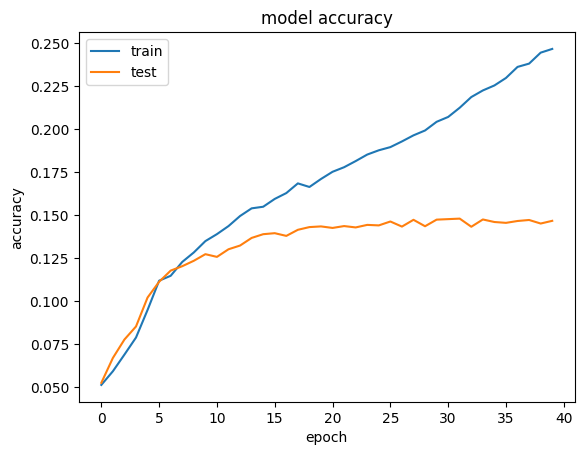

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

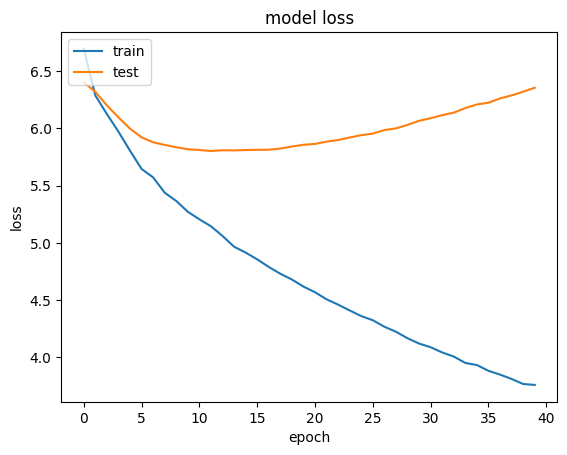

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
model.summary()